# Overview

The general idea of the visualization part was to play around with the `Bokeh` library in Python, defaulting to `matplotlib` if necessary, looks like I also briefly visited `seaborn`. Turns out to not have been the best time for an introduction to `Bokeh` as that project is undergoing significant restructuring as it remains a low-level API and significant functionality is moved into the more high-level `HoloViews` API, specifically the `bokeh.charts` has been deprecated but my code still uses that module.




In [53]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.metrics import confusion_matrix
import seaborn as sn
import bokeh
from bokeh.io import output_notebook


Bokeh is undergoing some significant changes (see `BokehDeprecationWarning` below) and many of the chart examples on the web won't work with the current version. I started with that latest version, then regressed to 0.12.0, and then back up to 0.12.6 in order to get some additional features.

In [54]:
print('pandas version:', pd.__version__)
print('bokeh version: ', bokeh.__version__)

pandas version: 0.21.0
bokeh version:  0.12.6


In [55]:
from bokeh.charts import Bar, Histogram, Donut, output_file, show, color
from bokeh.palettes import Spectral6, brewer
from bokeh.io import output_notebook
from bokeh.models.mappers import LinearColorMapper
from bokeh.models import ColorBar
from bokeh.layouts import row
# need this to output bokeh charts via Jupyter
output_notebook()

# for final project display suppress all warning messages
import warnings
warnings.simplefilter('ignore')

Loading BokehJS ...

In [56]:
vertica_pwd = 'cowcow'



Pull some of the baseline data in from Vertica via vertica_python library.

In [57]:
import ssl
import vertica_python


ssl_context = ssl.SSLContext(ssl.PROTOCOL_SSLv23)
ssl_context.verify_mode = ssl.CERT_NONE
ssl_context.check_hostname = False

# port forwarding of 5433 on VM to host OS
conn_info = {
    'host': 'localhost',
    'port': 5433,
    'user': 'dbadmin',
    'password': vertica_pwd,
    'database': 'vert'
#    ,'ssl': ssl_context,
}

with vertica_python.connect(**conn_info) as conn:
    data = pd.read_sql_query('SELECT * from proj.credit_fraud', conn)
    train = pd.read_sql_query('SELECT * from proj.credit_fraud_train_balanced', conn)

    
train.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V23,V24,V25,V26,V27,V28,Amount,Class,part,balanced
0,472.0,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,...,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,529.00,1,train,keep
1,509.0,-0.404841,1.005372,1.372756,0.005994,-0.118849,-0.788473,0.566918,0.114721,-0.521987,...,0.020848,0.456775,-0.249289,0.044937,0.234036,0.088356,8.28,0,train,keep
2,2623.0,0.931798,-0.711961,1.064823,0.166604,-0.706242,1.317450,-1.055541,0.672379,1.087952,...,0.120905,-0.569938,-0.210716,1.217113,0.018629,0.008026,49.50,0,train,keep
3,4358.0,-0.965104,1.203366,1.337760,1.455778,0.028224,0.045523,0.385188,0.054263,1.613467,...,-0.116710,-0.014050,-0.147504,-0.276134,0.224635,0.301919,24.71,0,train,keep
4,4462.0,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,...,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,239.93,1,train,keep


# Exploration

Beginning with the full dataset, do some exploration. First viz is very simple without any formatting.  
Notable:  
1) the raw count values are very imbalanced such that it appears as if all the transactions are in one of the first two low-euro-amount bins  
2) usually takes around 8 secons to generate the chart

In [58]:
%%time
hist = Histogram(data, values='Amount', title="Amount distribution", bins=20, plot_width=700)
show(hist)

Wall time: 11.9 s


Next is a much fancier histogram that shares a similar base purpose:  
1. The transformation of raw data into histogram is done on the db side
  - much quicker than above, usually 10x at least, and that is with relatively small dataset
  - some queries may be easier to write in SQL, either due to inherent features or because of user knowledge
- Euro amounts are displayed on a logarithmic scale, obvious now that most transactions are clustered in the low Amount range but that there are a few distibuted across the full \$0 - \$20k range
- Bin color is based on the relative occurrence of fraudulent transactions within a bin
  - the first bin likely has the highest raw number of fraudulent charges but the coloring reveals that as a percentage most fraudulent charges are occurring in the (Avg) \$1400 bin 
  - in fact there appear to be no fraudulent transactions greater than somewhere around \$3k
  - below query confirms, max fraudulent charge = $2,125.87
  <pre>SELECT MAX(Amount) FROM proj.credit_fraud WHERE Class = 1</pre>


In [59]:
%%time
HIST_SQL = """
-- https://stackoverflow.com/questions/44994183/vertica-generate-table-with-numbers-select-prime-numbers
WITH numbers AS (
    SELECT ROW_NUMBER() OVER() AS num FROM (
        SELECT 1 FROM (
            SELECT date(0) + INTERVAL '1 second' AS se UNION ALL
            SELECT date(0) + INTERVAL '1000 seconds' AS se ) a
        TIMESERIES tm AS '1 second' OVER(ORDER BY se)
    ) b
)
--SELECT num FROM seq ; 
,bins AS (
    SELECT bin, COUNT(*) AS BinSize, AVG(Amount)::int as BinAvgAmount, AVG(Class) * 1000 as FraudRatio
    FROM (
    SELECT Amount, Class, WIDTH_BUCKET(Amount, 0, (SELECT MAX(Amount) FROM proj.credit_fraud), 19) as bin
    FROM proj.credit_fraud
    ) A
    GROUP BY bin
    ORDER BY bin
)
SELECT n.num as bin, COALESCE(BinSize, 0) as BinSize, 
    CASE WHEN BinSize = 1 THEN 0.4 ELSE COALESCE(LN(BinSize), 0) END as LogBinSize, 
    'Bin ' || RIGHT('0' || n.num::char(2), 2) ||
        CASE WHEN COALESCE(BinAvgAmount, 0) = 0 THEN ' NA'
        ELSE '  $' || COALESCE(BinAvgAmount, 0)::char(10) 
        END as BinAvgAmount,
        COALESCE(WIDTH_BUCKET(FraudRatio, 0, 5, 6), 1) as FraudRatio
FROM numbers n 
LEFT JOIN bins b ON b.bin = n.num
WHERE n.num <= 20
ORDER BY n.num
"""

with vertica_python.connect(**conn_info) as conn:
    hist_data = pd.read_sql_query(HIST_SQL, conn)

print(hist_data[['bin','BinSize','LogBinSize','BinAvgAmount']].head(20))

color_mapper = LinearColorMapper(palette=brewer['RdYlGn'][6], low=0, high=10)
color_bar = ColorBar(color_mapper=color_mapper, location=(-85, 0), height=300,
                     title='Relative Fraud')
color_bar.title_text_align = 'center'

bar = Bar(hist_data, values='LogBinSize', label='BinAvgAmount', agg='mean', legend=None, 
          xlabel='Avg $ Amount in bin', ylabel='Log Amount',
          color=color(columns=['FraudRatio'], palette=brewer['RdYlGn'][4]),
          title="(Log) Amount Distribution", plot_width=800)
bar.add_layout(color_bar, 'right')
show(bar)


    bin  BinSize  LogBinSize    BinAvgAmount
0     1   247502   12.419174     Bin 01  $73
1     2     1944    7.572503   Bin 02  $1403
2     3      335    5.814131   Bin 03  $2511
3     4      149    5.003946   Bin 04  $3572
4     5       50    3.912023   Bin 05  $4554
5     6       21    3.044522   Bin 06  $5603
6     7       10    2.302585   Bin 07  $6719
7     8       10    2.302585   Bin 08  $7696
8     9        3    1.098612   Bin 09  $8646
9    10        1    0.400000  Bin 10  $10000
10   11        0    0.000000       Bin 11 NA
11   12        2    0.693147  Bin 12  $11844
12   13        1    0.400000  Bin 13  $12911
13   14        0    0.000000       Bin 14 NA
14   15        0    0.000000       Bin 15 NA
15   16        0    0.000000       Bin 16 NA
16   17        0    0.000000       Bin 17 NA
17   18        0    0.000000       Bin 18 NA
18   19        1    0.400000  Bin 19  $18910
19   20        1    0.400000  Bin 20  $19657


W-1005 (SNAPPED_TOOLBAR_ANNOTATIONS): Snapped toolbars and annotations on the same side MAY overlap visually: Chart(id='ebcaf15d-6d2e-4f70-b43e-e6150528b5e7', ...)


Wall time: 954 ms


# Balancing

Output some info on the training datasets, both the original and the balanced version

In [60]:
COUNT_SQL="""
SELECT Class, COUNT(*) As Cnt FROM proj.{table_name} GROUP BY Class
"""
sql_count_train_raw = COUNT_SQL.format(table_name='credit_fraud_train')
sql_count_train_balanced = COUNT_SQL.format(table_name='credit_fraud_train_balanced')

with vertica_python.connect(**conn_info) as conn:
    train_class_count_raw = pd.read_sql_query(sql_count_train_raw, conn)
    train_class_count_balanced = pd.read_sql_query(sql_count_train_balanced, conn)

print('preliminary cut for training dataset')
print(train_class_count_raw)
print()
print('balanced dataset used for modeling')
print(train_class_count_balanced)

preliminary cut for training dataset
   Class     Cnt
0      0  174654
1      1     297

balanced dataset used for modeling
   Class  Cnt
0      0  305
1      1  297


Below are `matplotlib` pie charts showing the distribution of fraudulent to non-fraudulent transactions in the training datasets  
1. on left is the full 175k dataset, fraud makes up a tiny fraction
- on the far right is the balanced dataset, much more closer in proportion but many fewer transactions overall
- nestled in the middle is the balanced pie chart, but in an overall area approximating the the size of the balanced training dataset vs. the unbalanced

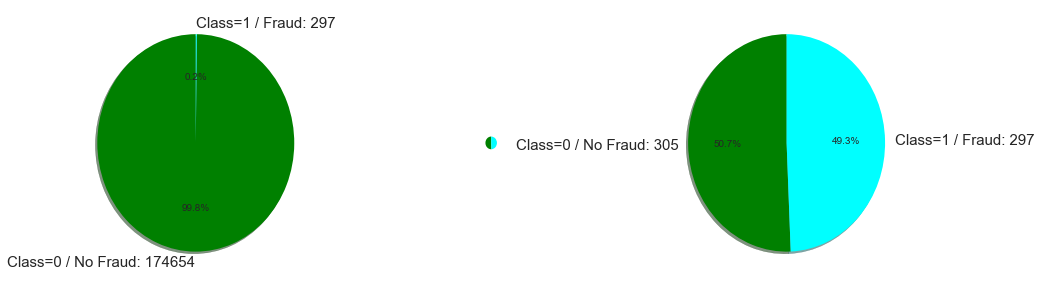

In [61]:
fig = plt.figure(figsize=(15, 5))
colors=['green', 'cyan']

ax1 = fig.add_subplot(131)
ax1.pie(train_class_count_raw['Cnt'], 
        labels=['Class=0 / No Fraud: {}'.format(train_class_count_raw['Cnt'][0])
                ,'Class=1 / Fraud: {}'.format(train_class_count_raw['Cnt'][1])],
        colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

ax2 = fig.add_subplot(133)
ax2.pie(train_class_count_balanced['Cnt'], 
        labels=['Class=0 / No Fraud: {}'.format(train_class_count_balanced['Cnt'][0])
                ,'Class=1 / Fraud: {}'.format(train_class_count_balanced['Cnt'][1])],
        colors=colors, autopct='%1.1f%%', shadow=True, startangle=90)

ax3 = fig.add_subplot(132)
ax3.pie(train_class_count_balanced['Cnt'], startangle=90, colors=colors, radius=0.0583095)

plt.show()


Next is a very simple bokeh version, noting that:
1. the Donut chart, as with other bokeh.chart objects, has been moved into the lightly-maintained `bkcharts` project
- there isn't much configuration that can be done on `Donut` from what I could tell, perhaps `HoloViews` has a whole new implementation
- there are much more fine grained ways of creating a pie chart, this one was very easy though

In [62]:
pie_chart_raw = Donut(train_class_count_raw, values='Cnt', label='Class', text_font_size='10pt')
pie_chart_balanced = Donut(train_class_count_balanced, values='Cnt', label='Class', text_font_size='10pt')

show(row(pie_chart_raw, pie_chart_balanced) )
    

# Model analysis


Displaying confustion matrix graphics for each of the various predictive models (and cutoffs in this case) can help in judging model accuracy, by displaying true/false positive and true/false negative counts.  
The `PREDICT_LOGISTIC_REG` function in Vertica is used to actually make predictions, but using different cutoff values as discussed in the Word document, where different cutoffs may be desirables depending on business reasoning. The `CONFUSION_MATRIX` function of Vertica is also called, more as a demonstration than anything - the actual details involved in the calculation are straightforward.

In [63]:

PRED_SQL="""
SELECT Class, PREDICT_LOGISTIC_REG(Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
USING PARAMETERS model_name='proj.log_model_1', cutoff={cutoff})::INT as PredClass
FROM proj.{table_name}
"""
sql_test_pred01 = PRED_SQL.format(cutoff=0.1, table_name='credit_fraud_test')
sql_test_pred25 = PRED_SQL.format(cutoff=0.25, table_name='credit_fraud_test')
sql_test_pred50 = PRED_SQL.format(cutoff=0.5, table_name='credit_fraud_test')

CM_SQL="""
SELECT CONFUSION_MATRIX(Class, PredClass USING PARAMETERS num_classes=2) OVER() FROM ({pred_sql}) A
"""

with vertica_python.connect(**conn_info) as conn:
    cm_test_data_01 = pd.read_sql_query(sql_test_pred01, conn)
    cm_test_data_25 = pd.read_sql_query(sql_test_pred25, conn)
    cm_test_data_50 = pd.read_sql_query(sql_test_pred50, conn)
    cm_01 = pd.read_sql_query(CM_SQL.format(pred_sql=sql_test_pred01), conn)
    
print(cm_test_data_01.head())
print()
print(cm_01)

   Class  PredClass
0      0          0
1      0          0
2      0          0
3      0          0
4      0          1

   class      0     1                                            comment
0      0  65082  9806                                                   
1      1      6   155  Of 75049 rows, 75049 were used and 0 were ignored


With the various dataframes populated the next step will be to create a series of confusion matrixes for each of the cutoffs. A confusion matrix on a highly imbalanced dataset is unlikely to be very useful...

[[65082  9806]
 [    6   155]]
[[69339  5549]
 [    8   153]]
[[71738  3150]
 [    9   152]]


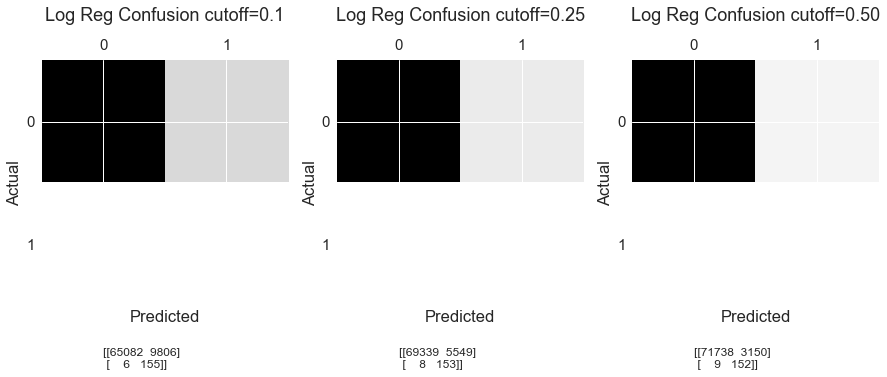

In [64]:
# function definition used in earlier class I took, CS109A
def plot_confusion_matrix(confusion, ax, title='Confusion matrix',cmap=plt.cm.gray_r):
    
    tot = float(confusion[0,0] + confusion[0,1] + confusion[1,0] + confusion[1,1])
 
    conf = np.empty([2,2])
     
    conf[0,0] = float(confusion[0,0]) / tot
    conf[0,1] = float(confusion[0,1]) / tot
    conf[1,0] = float(confusion[1,0]) / tot
    conf[1,1] = float(confusion[1,1]) / tot

    cax = ax.matshow(conf, cmap=cmap)
    ax.set_title(title)
    #fig.colorbar(cax)
    tick_marks = np.arange(len(conf[0]))
    plt.xticks(tick_marks)
    plt.yticks(tick_marks )
    
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    plt.text(0,2, confusion, size='large')
    
    return ax


fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(131)
cf_01 = confusion_matrix(cm_test_data_01['Class'],cm_test_data_01['PredClass'])
plot_confusion_matrix(cf_01, ax, 'Log Reg Confusion cutoff=0.1\n')
print(cf_01)

ax2 = fig.add_subplot(132)
cf_25 = confusion_matrix(cm_test_data_25['Class'],cm_test_data_25['PredClass'])
plot_confusion_matrix(cf_25, ax2, 'Log Reg Confusion cutoff=0.25\n')
print(cf_25)

ax3 = fig.add_subplot(133)
cf_50 = confusion_matrix(cm_test_data_50['Class'],cm_test_data_50['PredClass'])
plot_confusion_matrix(cf_50, ax3, 'Log Reg Confusion cutoff=0.50\n')
print(cf_50)

plt.show()

The imbalanced nature of the full test dataset indeed makes the output less than useful. Nonetheless, go ahead and try a different library instead of `matplotlib`. `Bokeh` didn't seem to have anything out-of-the-box (perhaps because I was only searching for "confusion matrix" instead of heatmap) but `Seaborn` did. Code is very simple so worth a shot. Create a single one based on the datframe returned by Vertica's `CONFUSION_MATRIX`.

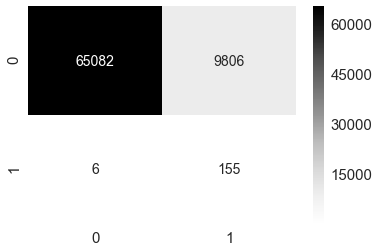

In [65]:
sn.set(font_scale=1.5)
sn.heatmap(cm_01[['0','1']], annot=True, annot_kws={'size': 14}, cmap='Greys', fmt='g')
plt.show()

This one is probably better because the numbers are embedded withing the graphic and the color scale comes by default (and it was basically one line of code). In terms of generating matrixes for actual evaluation though it would be better to use a balanced test dataset as the source.

In [66]:
sql_test_balanced_pred01 = PRED_SQL.format(cutoff=0.1, table_name='credit_fraud_test_balanced')
sql_test_balanced_pred25 = PRED_SQL.format(cutoff=0.25, table_name='credit_fraud_test_balanced')
sql_test_balanced_pred50 = PRED_SQL.format(cutoff=0.5, table_name='credit_fraud_test_balanced')

with vertica_python.connect(**conn_info) as conn:
    cm_test_balanced_data_01 = pd.read_sql_query(sql_test_balanced_pred01, conn)
    cm_test_balanced_data_25 = pd.read_sql_query(sql_test_balanced_pred25, conn)
    cm_test_balanced_data_50 = pd.read_sql_query(sql_test_balanced_pred50, conn)
    

[[138  16]
 [  6 155]]
[[146   8]
 [  8 153]]
[[150   4]
 [  9 152]]


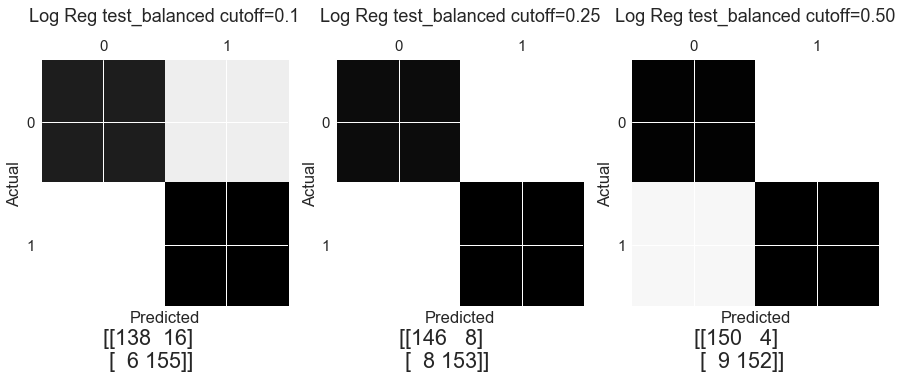

In [67]:
fig = plt.figure(figsize=[15,8])
ax = fig.add_subplot(131)
cf_01 = confusion_matrix(cm_test_balanced_data_01['Class'],cm_test_balanced_data_01['PredClass'])
plot_confusion_matrix(cf_01, ax, 'Log Reg test_balanced cutoff=0.1\n')
print(cf_01)

ax2 = fig.add_subplot(132)
cf_25 = confusion_matrix(cm_test_balanced_data_25['Class'],cm_test_balanced_data_25['PredClass'])
plot_confusion_matrix(cf_25, ax2, 'Log Reg test_balanced cutoff=0.25\n')
print(cf_25)

ax3 = fig.add_subplot(133)
cf_50 = confusion_matrix(cm_test_balanced_data_50['Class'],cm_test_balanced_data_50['PredClass'])
plot_confusion_matrix(cf_50, ax3, 'Log Reg test_balanced cutoff=0.50\n')
print(cf_50)

plt.show()

Two of the balanced datasets, now in `seaborn`, with some color added in this time.

[[138  16]
 [  6 155]]
[[146   8]
 [  8 153]]


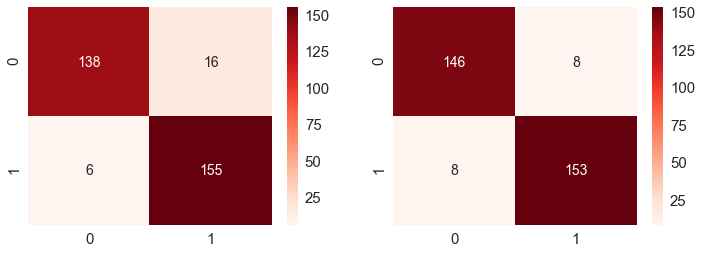

In [80]:
#sn.heatmap(cf_01, annot=True, annot_kws={'size': 14}, cmap='Reds', fmt='g')

fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=[12,4])

sn.heatmap(cf_01, annot=True, annot_kws={'size': 14}, cmap='Reds', fmt='g', ax=ax1)
sn.heatmap(cf_25, annot=True, annot_kws={'size': 14}, cmap='Reds', fmt='g', ax=ax2)

print(cf_01)
print(cf_25)
plt.show()